# DC2 Image Analysis, Crab, Upsampling

updated on 2024-05-30 (the commit 57352ad210f8e1a80cbab5d29730e8aaedf4f782)

This notebook explains image reconstruction using the pixel resolution of the model map finer than that of the response matrix.

Note that this notebook is advanced. It is assumed that you have already performed the two notebooks (Crab-DC2-ScAtt-DataReduction.ipynb, Crab-DC2-ScAtt-ImageDeconvolution.ipynb).

## Point

In the current implementation, the pixel size of the model map can be differnt from that of the response matrix. The model pixel size is used in the following instances:

- coordsys_conv_matrix
- image_deconvolution

Thus, make sure that NSIDE in these instances must be the same. In this notebook, I present the case with NSIDE = 16 in the model map.

When we convert the model map in the galactic coordinate to the detector coordinate, the pixel size will be downscaled so as the converted model map has the same pixel resolution matching the detector response.
Thus, using finer resolution in the model space does not improve the angular resolution in principle, while the reconstructed image will be smoother.

There are three different NSIDE defined in the analysis:

- NSIDE for the pixel resolution of the model (coordsys_conv_matrix, image_deconvolution)
- NSIDE for the pixel resolution of the response/data/background CDS (full_detector_response, inputs_Crab_DC2.yaml)
- NSIDE for the pixel resolution of the spacecraftattitude binning (exposure_table)

Normally, these three values are set equal, but in principle they can be different.

In [1]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataLoader, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

%matplotlib inline

Welcome to JupyROOT 6.24/06


21:17:01 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=363260;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=904421;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=212700;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=657329;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=258792;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=346894;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=254492;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=642924;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=591214;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=894;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=281602;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=967438;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=443906;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=43614;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=25797;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=203565;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=730621;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=613985;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/astromodels/core/parameter.py#704\704]8;;\

21:17:01 INFO      Starting 3ML!                                                                     ]8;id=480943;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=814159;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=138052;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=624248;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=460869;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=586287;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=926591;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=164697;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

21:17:02 WARNING   PyGMO is not available                                                      ]8;id=154597;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=140077;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

21:17:02 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=339625;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=403914;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=220153;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=400508;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=815273;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=272040;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=580083;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=33989;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=319725;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=793035;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=607740;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=621876;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=473136;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=15473;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-2-venv/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

In [2]:
nside_scatt_binning = 8
nside_model = 16

In this notebook I assume that the NSIDE for the exposure table is the same as in Crab-DC2-ScAtt-DataReduction.ipynb. So the binned data will be reused.

# 0. Prepare the data

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5 (please unzip it)
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori

From docs/tutorials/image_deconvolution/Crab/ScAttBinning
- inputs_Crab_DC2.yaml
- crab_spec.dat

As outputs from the notebook Crab-DC2-ScAtt-DataReduction.ipynb
- Crab_scatt_binning_DC2_bkg.hdf5
- Crab_scatt_binning_DC2_event.hdf5

## Load the response and orientation files

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "path/to/data/"

In [4]:
%%time

ori_filepath = path_data + "20280301_3_month.ori"
ori = SpacecraftFile.parse_from_file(ori_filepath)

CPU times: user 15.9 s, sys: 1.18 s, total: 17 s
Wall time: 16.7 s


In [5]:
full_detector_response_filename = path_data + "SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5"
full_detector_response = FullDetectorResponse.open(full_detector_response_filename)

nside_local = full_detector_response.nside
npix_local = hp.nside2npix(nside_local)

nside_local

8

In [6]:
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 768
    NSIDE: 8
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 36
    EDGES: [0.0 deg, 5.0 deg, 10.0 deg, 15.0 deg, 

# 1. analyze the orientation file

This section is the same as in Crab-DC2-ScAtt-DataReduction.ipynb.

In [7]:
%%time

exposure_table = SpacecraftAttitudeExposureTable.from_orientation(ori, nside = nside_scatt_binning, start = None, stop = None)
exposure_table

angular resolution:  7.329037678543799 deg.



WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"



duration:  92.36059027777777 d



WARNING ErfaWarning: ERFA function "utctai" yielded 7979955 of "dubious year (Note 3)"



  0%|          | 0/7979955 [00:00<?, ?it/s]

CPU times: user 31 s, sys: 1.64 s, total: 32.7 s
Wall time: 32.6 s


,scatt_binning_index,healpix_index,zpointing,xpointing,zpointing_averaged,xpointing_averaged,delta_time,exposure,num_pointings,bkg_group
0,0,"(532, 13)","[[44.62664815323754, -21.585226694584346], [44...","[[44.62664815323755, 68.41477330541565], [44.6...","[44.77592919492308, -21.83137450725276]","[44.79590102793104, 68.17007080261746]","[0.9999999999969589, 1.0000000000065512, 0.999...",71072.0,71072,0
1,1,"(532, 26)","[[45.66020516346508, -23.269427365755966], [45...","[[45.6602051634651, 66.73057263424403], [45.69...","[45.955010022713545, -23.741156770888438]","[45.95764244902919, 66.25906763976249]","[1.0000000000065512, 0.9999999999969589, 0.999...",26359.0,26359,0
2,2,"(532, 42)","[[46.29919922293719, -24.286823740507035], [46...","[[46.29919922293719, 65.71317625949297], [46.3...","[47.169799754806256, -25.642813300423782]","[47.188380045186555, 64.35902575261872]","[0.9999999999969589, 0.9999999999969589, 1.000...",71137.0,71137,0
3,3,"(564, 42)","[[48.1115581160702, -27.07000329743496], [48.1...","[[48.111558116070206, 62.92999670256505], [48....","[49.549399237968544, -29.168814518824405]","[49.59320571194872, 60.83674837374497]","[0.9999999999969589, 1.0000000000065512, 0.999...",111115.0,111115,0
4,4,"(564, 63)","[[51.09862804289071, -31.321406880638527], [51...","[[51.09862804289071, 58.67859311936147], [51.1...","[51.90542254254405, -32.39811966891759]","[51.917215575378705, 57.603714738909005]","[0.9999999999969589, 1.0000000000065512, 0.999...",57871.0,57871,0
...,...,...,...,...,...,...,...,...,...,...
133,133,"(468, 13)","[[40.16189499252812, -13.801710443269755], [40...","[[40.161894992528104, 76.19828955673026], [40....","[40.89892831460051, -15.138427135287458]","[40.92208802371745, 74.8623891583036]","[1.0000000000065512, 0.9999999999969589, 0.999...",67576.0,67576,0
134,134,"(499, 13)","[[41.655148156368654, -16.49006256585185], [41...","[[41.655148156368654, 73.50993743414816], [41....","[42.7796358426142, -18.460371889534287]","[42.82335612555313, 71.54190445396517]","[0.9999999999969589, 1.0000000000065512, 0.999...",99833.0,99833,0
135,135,"(716, 188)","[[145.12720043519377, -61.03941171474516], [14...","[[145.12720043519377, 28.960588285254847], [14...","[145.15270150626816, -61.035193201971055]","[145.1526970180014, 28.964811462201155]","[0.9999999999969589, 0.9999999999969589, 1.000...",992.0,992,0
136,136,"(128, 128)","[[180.0238082643748, 46.67626678787605], [180....","[[180.0238082643748, 43.32373321212394], [180....","[180.01420731505038, 46.68360608975279]","[180.01420553833427, 43.316394483057174]","[0.9999999999969589, 1.000000000001755, 1.0000...",646.0,646,0


You can save SpacecraftAttitudeExposureTable as a fits file.

In [8]:
exposure_table.save_as_fits(f"exposure_table_nside{nside_scatt_binning}.fits", overwrite = True)

You can also read the fits file.

In [8]:
exposure_table_from_fits = SpacecraftAttitudeExposureTable.from_fits(f"exposure_table_nside{nside_scatt_binning}.fits")
exposure_table == exposure_table_from_fits

True

# 2. Calculate the coordinate conversion matrix

CoordsysConversionMatrix.spacecraft_attitude_binning_ccm can produce the coordinate conversion matrix for the spacecraft attitude binning.

In this calculation, we calculate the exposure time map in the detector coordinate for each model pixel and each scatt_binning_index. We refer to it as the dwell time map.

If use_averaged_pointing is True, first the averaged Z- and X-pointings are calculated (the average of zpointing or xpointing in the exposure table) for each scatt_binning_index, and then the dwell time map is calculated assuming the averaged pointings for each model pixel and each scatt_binning_index.

If use_averaged_pointing is False, the dwell time map is calculated for each attitude in zpointing and xpointing (basically every 1 second), and then the calculated dwell time maps are summed up for each model pixel and each scatt_binning_index. 

In the former case, the computation is fast but may lose the angular resolution. In the latter case, the conversion matrix is more accurate, but it takes a very long time to calculate it.

In [10]:
%%time

coordsys_conv_matrix = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table, 
                                                                                nside_model = nside_model, use_averaged_pointing = True,
                                                                                earth_horizon_angle = 113.0 * u.deg)

  0%|          | 0/138 [00:00<?, ?it/s]

The zenith angle of the earth horizon is assumed to be 113.0 deg. Note that currently we assume that the satellite points to the zenith.


CPU times: user 5min 19s, sys: 6.68 s, total: 5min 25s
Wall time: 5min 20s


You can save CoordsysConversionMatrix as a hdf5 file.

In [11]:
coordsys_conv_matrix.write(f"ccm_nside{nside_model}.hdf5", overwrite = True)

You can also read the saved file.

In [9]:
coordsys_conv_matrix = CoordsysConversionMatrix.open(f"ccm_nside{nside_model}.hdf5")

**Check the matrix shape**

In [10]:
coordsys_conv_matrix.contents

Format,coo
Data Type,float64
Shape,"(138, 3072, 768)"
nnz,1165856
Density,0.0035808274519424314
Read-only,True
Size,35.6M
Storage ratio,0.0


# 3. Load the binned data

Since NSIDE of exposure_table on this notebook is the same as that in Crab-DC2-ScAtt-DataReduction.ipynb, you can use the files generated before.

In [11]:
%%time

#  background 
bkg_data = BinnedData("inputs_Crab_DC2.yaml")
bkg_data.load_binned_data_from_hdf5("Crab_scatt_binning_DC2_bkg.hdf5")

#  signal + background
Crab_data = BinnedData("inputs_Crab_DC2.yaml")
Crab_data.load_binned_data_from_hdf5("Crab_scatt_binning_DC2_event.hdf5")

CPU times: user 60.4 ms, sys: 265 ms, total: 326 ms
Wall time: 342 ms


# 4. Imaging deconvolution

## 4-1. Prepare DataLoader containing all neccesary datasets

In [12]:
dataloader = DataLoader.load(Crab_data.binned_data, 
                             bkg_data.binned_data, 
                             full_detector_response,
                             coordsys_conv_matrix,
                             is_miniDC2_format = False)

In [13]:
dataloader._modify_axes()


WARNING FutureWarning: Note that _modify_axes() in DataLoader was implemented for a temporary use. It will be removed in the future.


WARNING UserWarning: Make sure to perform _modify_axes() only once after the data are loaded.



... checking the axis ScAtt of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.


## 4-2. Load the response file

In [14]:
%%time

dataloader.load_full_detector_response_on_memory()
dataloader.calc_image_response_projected() # mandatory

... (DataLoader) calculating a projected image response ...
CPU times: user 2.98 s, sys: 10.7 s, total: 13.7 s
Wall time: 18.4 s


## 4-3. Initialize the instance of the image deconvolution class

In [15]:
parameter_filepath = "imagedeconvolution_parfile_scatt_Crab.yml"

In [16]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x3f8f2b220>
parameter file for image deconvolution was set ->  imagedeconvolution_parfile_scatt_Crab.yml


## 4-4. modify the parameters

**Do not forget to make sure that NSIDE of the model map is modified to 16**

In [17]:
image_deconvolution.override_parameter(f"model_property:nside = {nside_model}")

In [18]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 20")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 5")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 2.0")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 158.489
- 251.189
- 398.107
- 630.957
- 1000.0
- 1584.89
- 2511.89
- 3981.07
- 6309.57
- 10000.0
nside: 16
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/3072 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 5
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 20
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 2.0

#### Done ####



## 4-5. Start the image deconvolution

**With MacBook Pro with M1 Max and 64 GB memory, it takes about 9 minutes for 20 iterations.**

In [19]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/20 [00:00<?, ?it/s]

  Iteration 1/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 4.744004854279645
    loglikelihood: 23011594.803452194
    background_normalization: 1.0651599375545466
  Iteration 2/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 23406360.62533669
    background_normalization: 0.9987196134882835
  Iteration 3/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 23606641.03169772
    background_normalization: 0.9918312686893154
  Iteration 4/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 23743843.25070761
    background_normalization: 0.9883829578312177
  Iteration 5/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 23845340.577709235
    background_normalization: 0.9866460707213961
  Iteration 6/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 23925581.17844256
    background_normalization: 0.9859916915233784
  Iteration 7/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 23991959.826505207
    background_normalization: 0.98598433236484
  Iteration 8/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24048415.28228102
    background_normalization: 0.9863391488707774
  Iteration 9/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24097240.475589298
    background_normalization: 0.98687934019269
  Iteration 10/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24139918.89710465
    background_normalization: 0.9874993693161705
  Iteration 11/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24177503.552477233
    background_normalization: 0.9881384734949162
  Iteration 12/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24210793.541169062
    background_normalization: 0.9887631515439634
  Iteration 13/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24240421.95590429
    background_normalization: 0.9893561175607506
  Iteration 14/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24266903.874059044
    background_normalization: 0.9899095318770726
  Iteration 15/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24290665.36067936
    background_normalization: 0.9904209328148106
  Iteration 16/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24312062.703458577
    background_normalization: 0.9908908262316883
  Iteration 17/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24331396.143613547
    background_normalization: 0.9913212739966656
  Iteration 18/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24348920.205290735
    background_normalization: 0.9917150768876233
  Iteration 19/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24364851.742179118
    background_normalization: 0.9920753081800574
  Iteration 20/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...



WARNING RuntimeWarning: divide by zero encountered in divide



--> checking stopping criteria
--> --> stop
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 24379376.347795174
    background_normalization: 0.992405052920716
#### Done ####

CPU times: user 41min 55s, sys: 4min 23s, total: 46min 18s
Wall time: 7min 5s


In [20]:
import pprint

pprint.pprint(all_results)

[{'alpha': <Quantity 4.74400485>,
  'background_normalization': 1.0651599375545466,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3f9b13250>,
  'iteration': 1,
  'loglikelihood': 23011594.803452194,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3f9b13970>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3f9b11720>},
 {'alpha': 1.0,
  'background_normalization': 0.9987196134882835,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3f9b10e20>,
  'iteration': 2,
  'loglikelihood': 23406360.62533669,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3f9b12a10>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3f9b139a0>},
 {'alpha': 1.0,
  'background_normalization': 0.9918312686893154,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3f9b13d60>,
  'iteration': 3,
  'loglikelihood': 23606641.03169772

**(If you want, you can save the results in the directory "./results" as follows)**

In [27]:
import os

os.mkdir("./results")

for result in all_results:
    iteration = result['iteration']
    result['model_map'].write(f'./results/model_map_itr{iteration}.hdf5')

    with open(f'./results/result_itr{iteration}.txt', 'w') as f:
        paramlist = ['alpha', 'loglikelihood', 'background_normalization']

        for param in paramlist:
            value = result[param]
            f.write(f'{param}: {value}\n')

# 5. Analyze the results
Examples to see/analyze the results are shown below.

In [21]:
## Crab location

source_position = {"l":184.600, "b": -5.800}

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

Text(0, 0.5, 'loglikelihood')

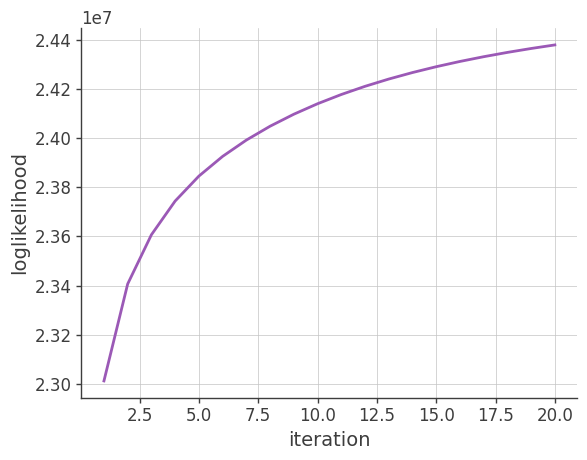

In [22]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

Text(0, 0.5, 'alpha')

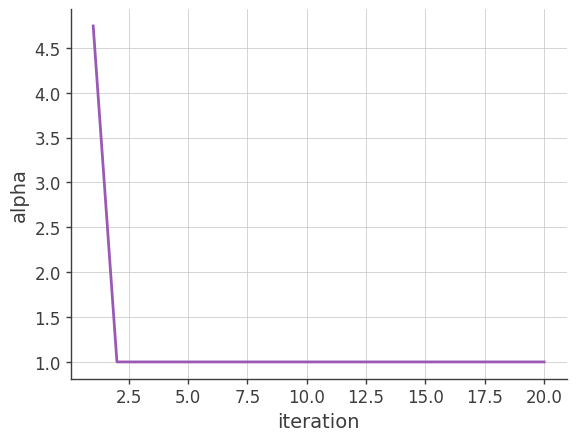

In [23]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the background model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

Text(0, 0.5, 'background_normalization')

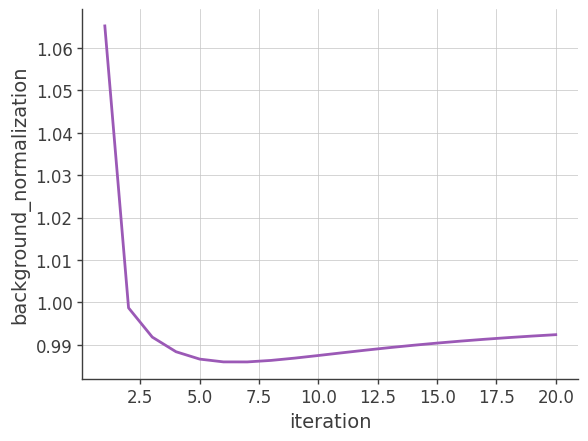

In [24]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")

## The reconstructed images

In [25]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

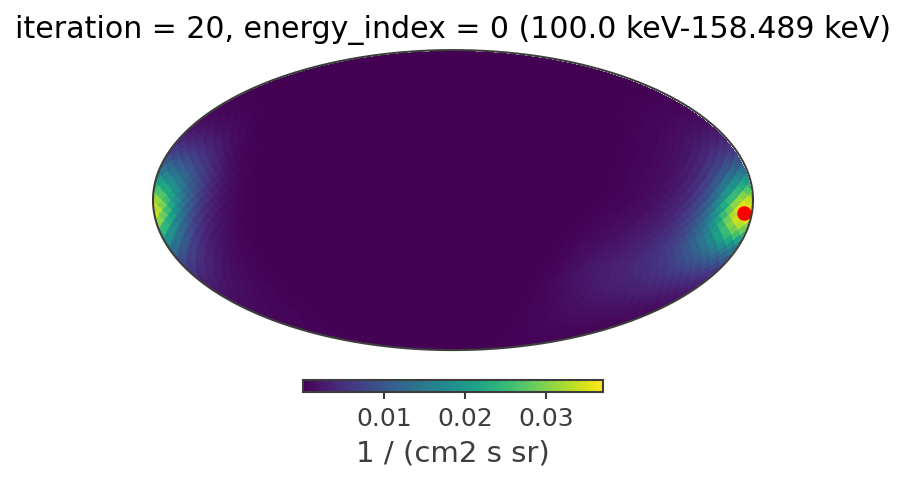

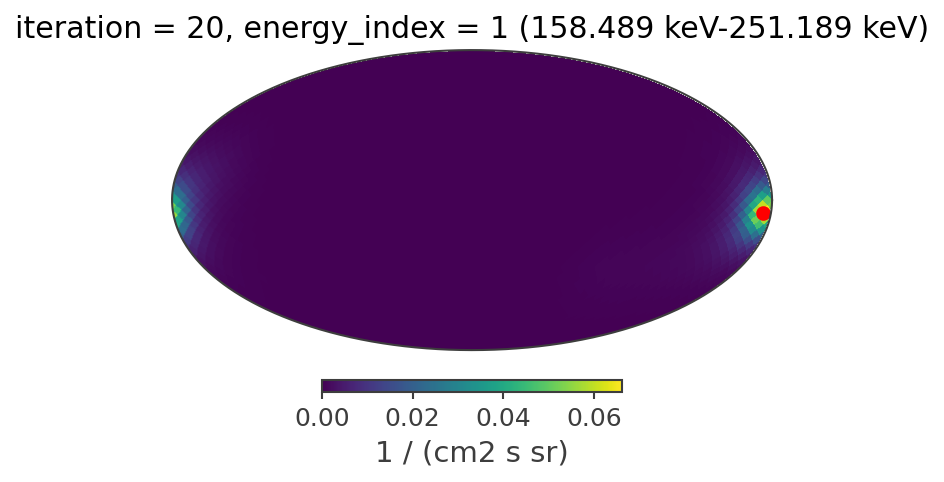

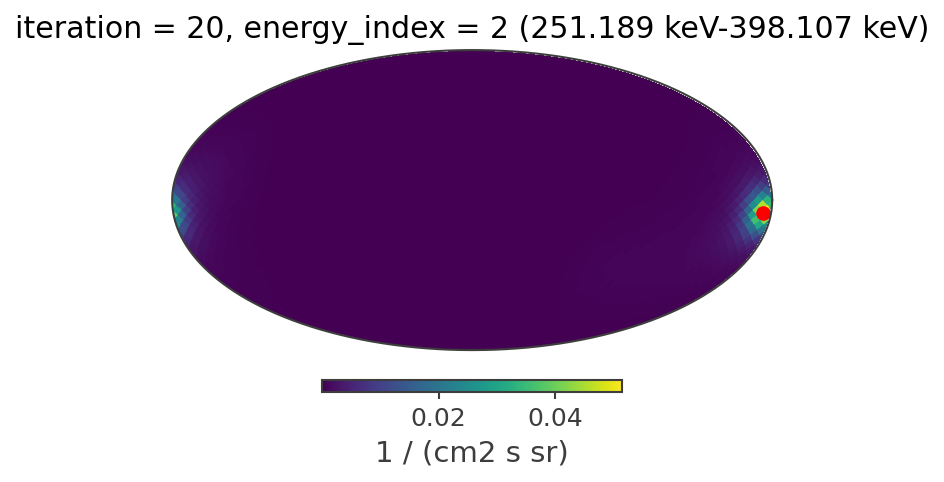

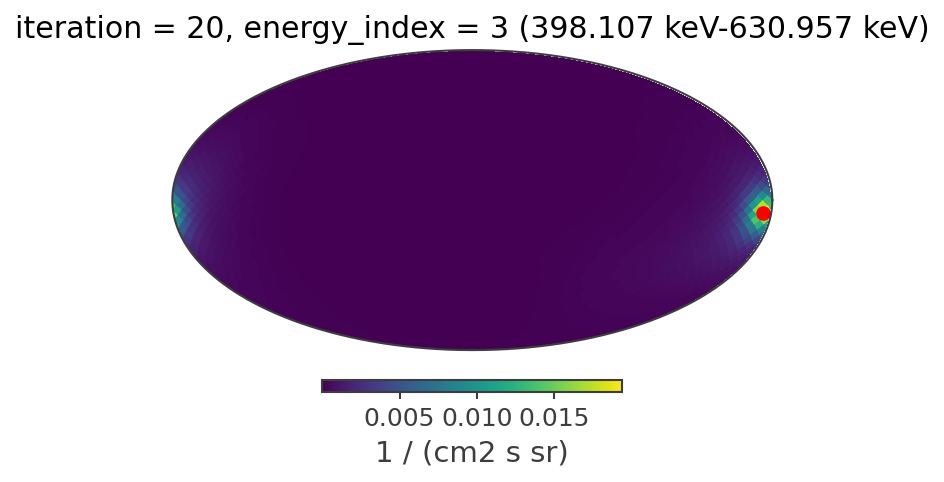

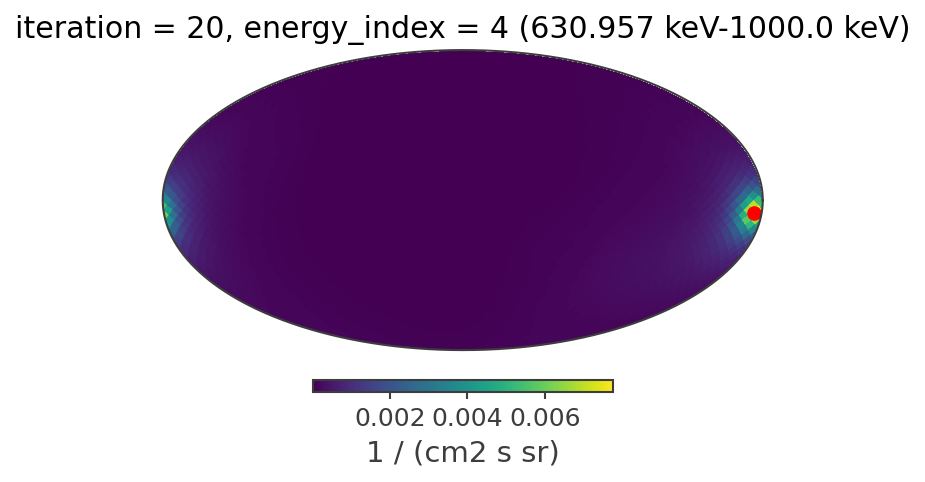

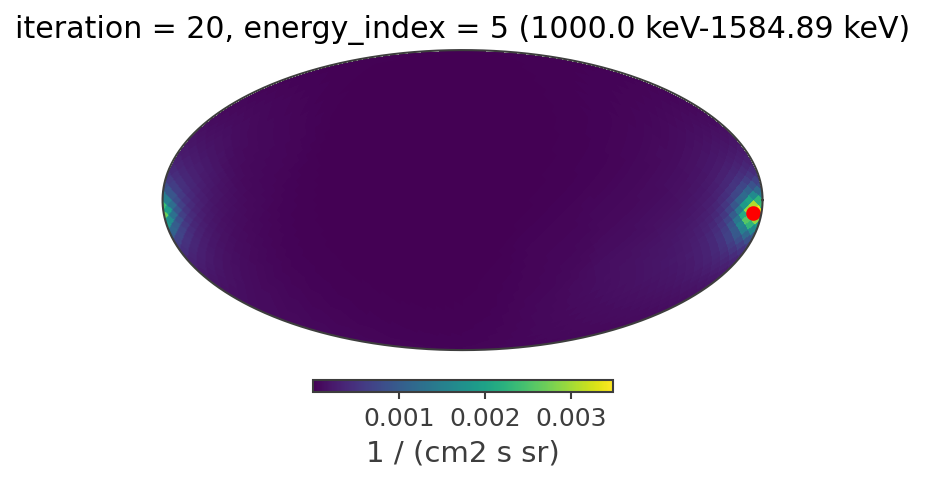

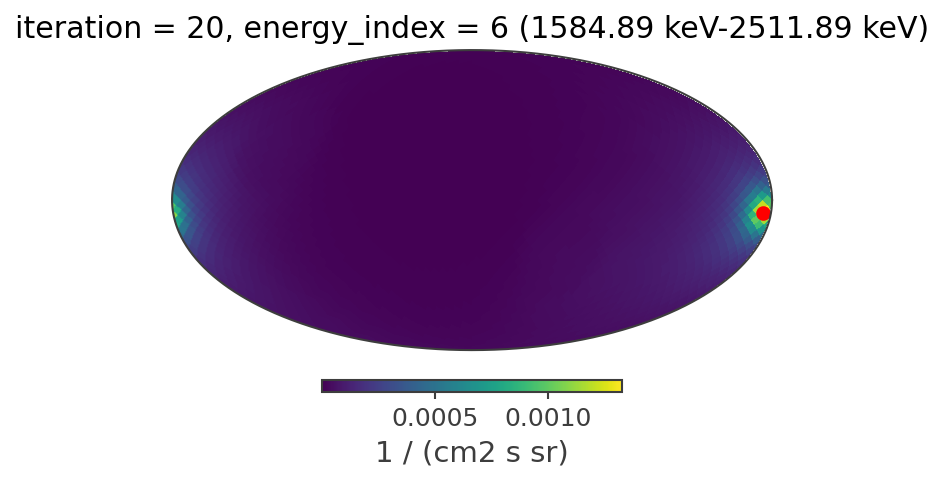

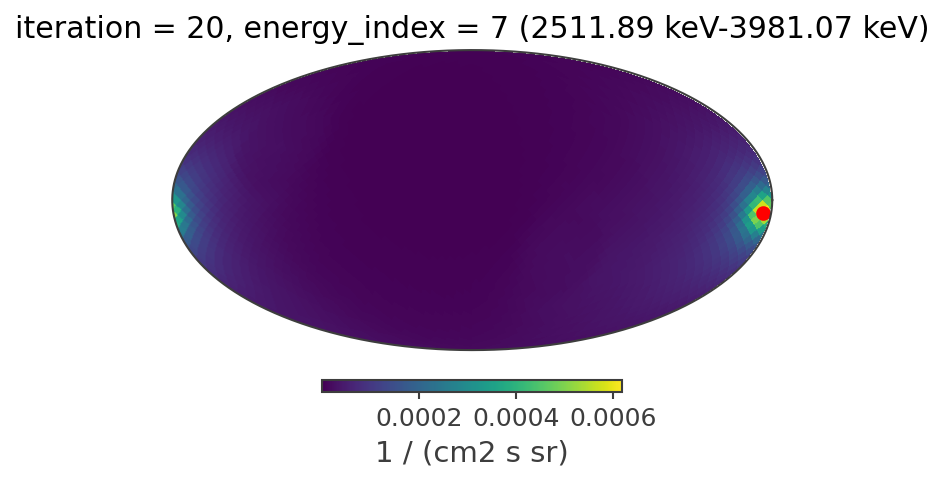

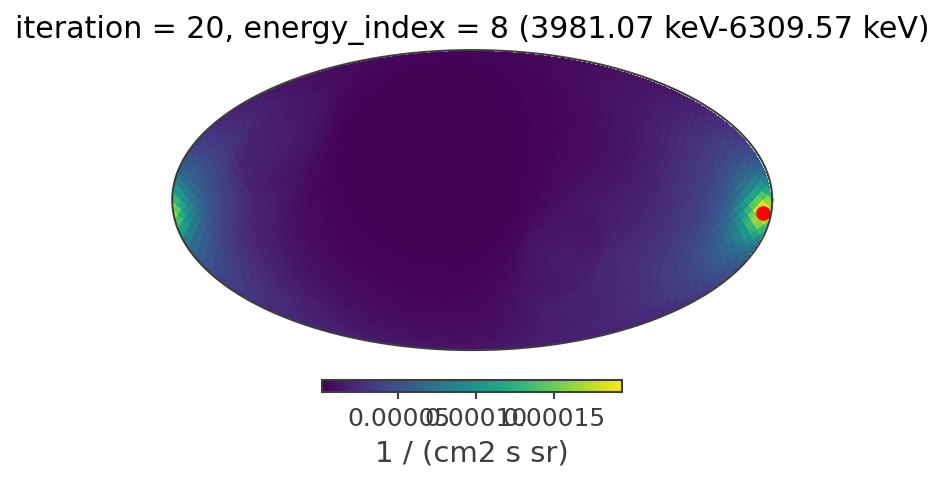

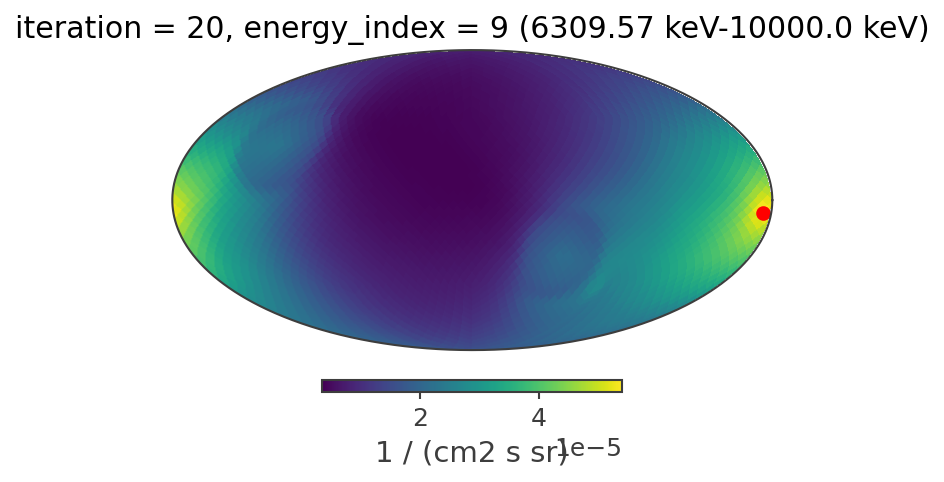

In [26]:
iteration = 19

plot_reconstructed_image(all_results[iteration], source_position = (source_position['l'] * u.deg, source_position['b'] * u.deg))

## Spectrum

Plotting the gamma-ray spectrum at 20th iteration. The photon flux at each energy band shown here is calculated as the accumulation of the flux values in all pixel at each energy band.

In [27]:
energy_truth = []
flux_truth = []

with open("crab_spec.dat", "r") as f:
    for line in f:
        data = line.split('\t')
        if data[0] == 'DP':
            energy_truth.append(float(data[1]))# * u.keV)
            flux_truth.append(float(data[2]))# / u.cm**2 / u.s / u.keV)

In [28]:
def get_differential_flux(model_map):
    pixelarea = 4 * np.pi / model_map.axes['lb'].npix * u.sr
        
    differential_flux = np.sum(model_map, axis = 0) * pixelarea / model_map.axes['Ei'].widths
    
    return differential_flux

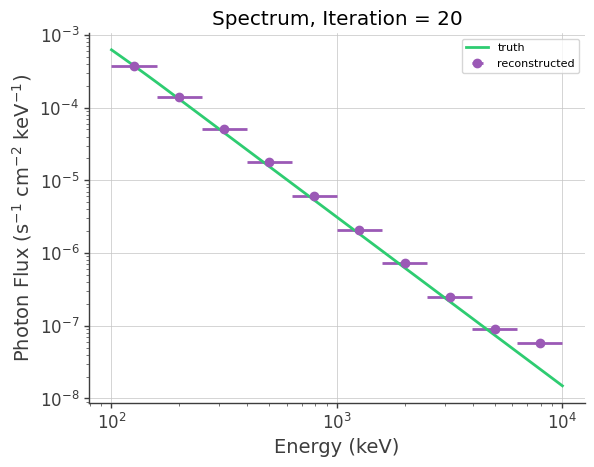

In [29]:
iteration = 19

result = all_results[iteration]

model_map = result['model_map']

differential_flux = get_differential_flux(model_map)

energy_band = model_map.axes['Ei'].centers

err_energy = model_map.axes['Ei'].bounds.T - model_map.axes['Ei'].centers
err_energy[0,:] *= -1
        
plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.plot(energy_truth, flux_truth, label = 'truth')
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {result['iteration']}")
plt.grid()
plt.legend()

## check the discrepancy between the model and reconstructed spectrum

In [30]:
import scipy.interpolate as interpolate

f = interpolate.interp1d(np.log(np.array(energy_truth)), np.log(np.array(flux_truth))) # log-linear interpolation

for idx, e_center in enumerate(energy_band):
    truth_value_interpolated = np.exp(f(np.log(e_center.value)))
    print(f"Energy Center: {e_center}, Truth: {truth_value_interpolated}, Reconstructed: {differential_flux[idx]}")
    print(f"diff: {(differential_flux[idx].value / truth_value_interpolated - 1)*1e2:.2f} %")

Energy Center: 125.8924143862528 keV, Truth: 0.00037509332308051504, Reconstructed: 0.00037156335438032385 1 / (cm2 keV s)
diff: -0.94 %
Energy Center: 199.52617227070743 keV, Truth: 0.00013100640643159297, Reconstructed: 0.00013896247916373217 1 / (cm2 keV s)
diff: 6.07 %
Energy Center: 316.2279229021369 keV, Truth: 4.5008043531443166e-05, Reconstructed: 5.118128401999745e-05 1 / (cm2 keV s)
diff: 13.72 %
Energy Center: 501.1869894550339 keV, Truth: 1.5462910559040303e-05, Reconstructed: 1.8038955127348068e-05 1 / (cm2 keV s)
diff: 16.66 %
Energy Center: 794.3280178868179 keV, Truth: 5.312405290582567e-06, Reconstructed: 6.151229940284527e-06 1 / (cm2 keV s)
diff: 15.79 %
Energy Center: 1258.924143862529 keV, Truth: 1.825139915500053e-06, Reconstructed: 2.096270940953966e-06 1 / (cm2 keV s)
diff: 14.86 %
Energy Center: 1995.2617227070734 keV, Truth: 6.270348197761169e-07, Reconstructed: 7.317968646472885e-07 1 / (cm2 keV s)
diff: 16.71 %
Energy Center: 3162.279229021372 keV, Truth: 2.

## Plot All

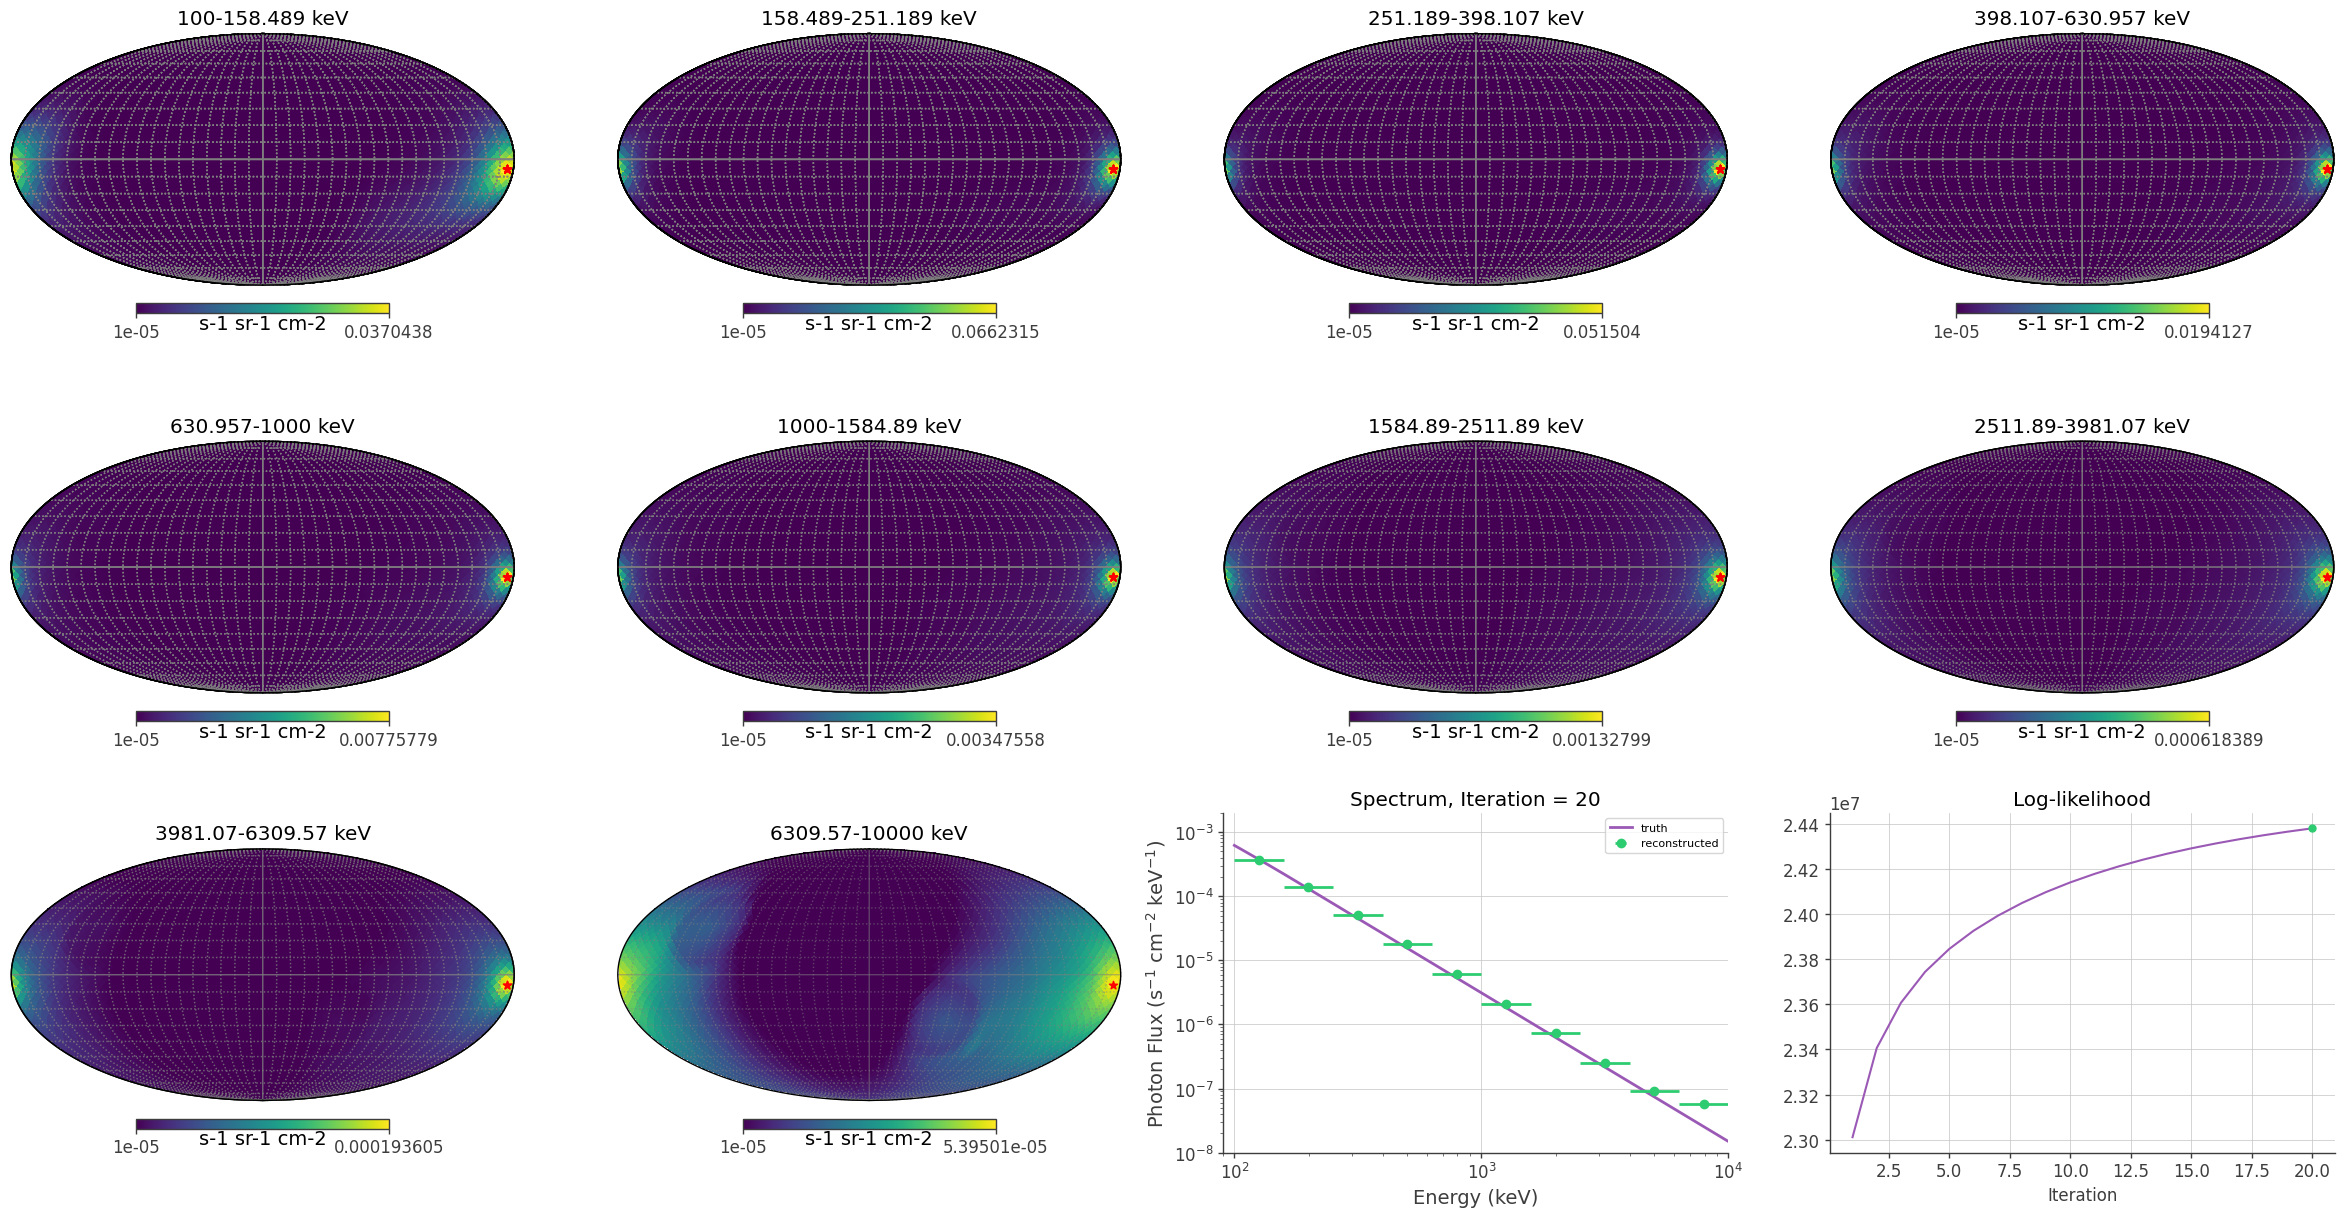

In [31]:
title = ["100-158.489 keV",
"158.489-251.189 keV", 
"251.189-398.107 keV", 
"398.107-630.957 keV", 
"630.957-1000 keV", 
"1000-1584.89 keV", 
"1584.89-2511.89 keV", 
"2511.89-3981.07 keV", 
"3981.07-6309.57 keV", 
"6309.57-10000 keV"]

position = {"l":184.600, "b": -5.800}

i_iteration = 19 # ==>20th iteration
th = -5

fig = plt.figure(figsize=(30, 15))
gs = GridSpec(nrows=3, ncols=4)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[1, 3])
ax8 = fig.add_subplot(gs[2, 0])
ax9 = fig.add_subplot(gs[2, 1])

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    
ax_spectrum = fig.add_subplot(gs[2, 2])
ax_likelihood = fig.add_subplot(gs[2, 3])
#ax_background = fig.add_subplot(gs[1, 3])

#plt.subplots_adjust(wspace=0.4, hspace=0.5)

image = all_results[i_iteration]['model_map']

for i_energy in range(image.axes['Ei'].nbins):   
    plt.axes(axes[i_energy])

    data = image.contents[:,i_energy]
    data[data < 10**th * image.unit] = 10**th * image.unit

    hp.mollview(data, norm = 'liner', min = 10**th, title = title[i_energy], hold=True, unit = "s-1 sr-1 cm-2")
    hp.graticule(color='gray', dpar = 10, alpha = 0.5)
    hp.projscatter(theta = position["l"], phi = position["b"], lonlat = True, color = 'red', linewidths = 1, marker = "*")

###        
        
plt.axes(ax_spectrum)

energy_band = image.axes['Ei'].centers

err_energy = image.axes['Ei'].bounds.T - image.axes['Ei'].centers
err_energy[0,:] *= -1

differential_flux = get_differential_flux(image)
    
plt.plot(energy_truth, flux_truth, label = 'truth')

plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.xscale("log")
plt.yscale("log")
plt.xlim(90, 10000)
plt.ylim(1e-8, 2e-3)
    
plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {iteration+1}")
plt.grid()
plt.legend()
        
###        
        
plt.axes(ax_likelihood)

iterations = [_['iteration'] for _ in all_results]
loglikelihoods = [_['loglikelihood'] for _ in all_results]

plt.plot(iterations, loglikelihoods, linewidth = 1.5)
plt.plot([iterations[i_iteration]], [loglikelihoods[i_iteration]], markersize = 10, marker = ".")

plt.xlabel("Iteration", fontsize = 12)
plt.title("Log-likelihood")
plt.grid()

###
#    plt.axes(ax_background)

#    plt.plot(iterations, background_normalizations, linewidth = 1.5)
#    plt.plot([iterations[i]], [background_normalizations[i]], markersize = 10, marker = ".")

#    plt.xlabel("Iteration", fontsize = 12)
    #plt.ylabel("Background Normalization", fontsize = 12)
#    plt.ylim(0.7, 1.4)
#    plt.title("Background Normalization")
#    plt.grid()    

#    plt.savefig(f"fig_{i:03}.png")